In [1]:
%matplotlib inline
import tweepy
import pandas as pd
import json
import numbers
import re
import os.path
import datetime

pd.options.display.max_colwidth = 400
pd.options.display.max_rows = 25
pd.options.display.max_columns = None

# Saving real-time tweets from Twitter's streaming service with Tweepy and querying the data with Pandas

Create a Twitter app at https://apps.twitter.com. Then generate an access token.

If you have any problems running the first cell, you'll need to either `pip install` those packages manually (e.g. `pip install tweepy`) or run `pip install -r requirements.txt`.

The github repo comes with a credentials.txt file, where you can fill in your consumer keys and access tokens. Rename it to credentials.ini and it will not be uploaded to your repo if you push. You can then also safely share the output of ipynb file without disclosing your keys/tokens.

In [2]:
def load_credentials():
    consumer_key, consumer_key_secret, access_token, access_token_secret = (None,)*4
    if not os.path.isfile('credentials.ini'): 
        return consumer_key, consumer_key_secret, access_token, access_token_secret
    lines = [line.rstrip('\n') for line in open('credentials.ini')]
    chars_to_strip = " \'\""
    for line in lines:
        if "consumer_key" in line and 'fill_in' not in line:
            consumer_key = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
        if "consumer_secret" in line and 'fill_in' not in line:
            consumer_key_secret = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
        if "access_token" in line and 'fill_in' not in line:
            access_token = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
        if "access_secret" in line and 'fill_in' not in line:
            access_token_secret = re.findall(r'[\"\']([^\"\']*)[\"\']', line)[0]
    return consumer_key, consumer_key_secret, access_token, access_token_secret

However, you can also input them directly into the cell below if you wish for convenience.

In [3]:
consumer_key, consumer_key_secret, access_token, access_token_secret = load_credentials()
if not all([consumer_key, consumer_key_secret, access_token, access_token_secret]):
    consumer_key = 'fill_in_if_not_in_credentials_ini'
    consumer_key_secret = 'fill_in_if_not_in_credentials_ini'
    access_token = 'fill_in_if_not_in_credentials_ini'
    access_token_secret = 'fill_in_if_not_in_credentials_ini'
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

Testing to make sure that it works. This is pulling 20 tweets from your own Twitter timeline (tweets from ppl you follow). If tweets print out below, then your credentials are all set!

In [4]:
tweets_raw_data = []
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print tweet.text
    tweets_raw_data.append(tweet)

When I'm dressed up, I usually assume people near me in suits are going to the same place. Then I remembered I'm on Wall Street. #NBAwards
RT @chrislhayes: @nathanjurgenson @zunguzungu good point, and it's the *same incentives* producing both kinds of content.
RT @jomc: @nathanjurgenson also discussed a lot of these issues last year here https://t.co/2EWJf18P0T
Celebrating music and ideas, in my home away from Hong Kong. @CarmelBach is of the many reasons I love the Monterey… https://t.co/1SJLY14nIA
it's like the dream of the hippies came true and all the world's leaders finally dropped acid and tuned in https://t.co/rbTcwvYeyW
RT @clairecm: "State Dept confirms that, like Pentagon &amp; Justice, it has not heard from anyone on President-elect Trump’s team" https://t.c…
Theranos Whistleblower Shook the Company—And His Family - WSJ theranos execs need to go to jail  https://t.co/Csx1aqV0mx
In the new regime, @elivalley will be a light in dark, dark times https://t.co/ZsX2Sk1R1J
RT @mrko

To see some of the raw data in each tweet, you can take a look at each tweet's json.

In [5]:
tweets_raw_data[0]._json

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Wed Nov 16 23:24:48 +0000 2016',
 u'entities': {u'hashtags': [{u'indices': [129, 138], u'text': u'NBAwards'}],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': None,
 u'id': 799030487578791937,
 u'id_str': u'799030487578791937',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'en',
 u'place': None,
 u'retweet_count': 0,
 u'retweeted': False,
 u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 u'text': u"When I'm dressed up, I usually assume people near me in suits are going to the same place. Then I remembered I'm on Wall Street. #NBAwards",
 u'truncated': False,
 u'user': {u'contributors_enabled': False,
  u'created_at': u'Sat Nov 25 02:00:17 +0000 2006

In [6]:
# https://github.com/tweepy/tweepy/blob/v3.5.0/docs/streaming_how_to.rst
class MyStreamListener(tweepy.StreamListener):
    """ Options you can set by passing to the MyStreamListener object:
        limit: int, how many tweets to capture
        print_output: bool, whether to print the tweet to screen
        save_output: bool, whether to save the tweet data to a csv file
        filename: str, the filename to name the saved output, by default it's file.csv
        include_rts: bool, whether to capture retweets
        strict_text_search: bool, ocasionally, stream will capture a tweet that doesn't actually include the search query
            set to True to filter out these "accidental" tweets
        search_terms: str or array, pass in the search query or an array of terms you want to use for filtering
            if strict_text_search = True. Script checks and turns any string into array of strings
    """
    def __init__(self,limit=20,print_output=True,save_output=True,
                 filename='file.csv',include_rts=True,strict_text_search=False,
                 search_terms=None):
        self.df = pd.DataFrame()
        self.limit = limit
        self.counter = 0
        self.print_output = print_output
        self.header=False
        self.save_output=save_output
        self.filename=filename
        self.include_rts=include_rts
        self.strict_text_search = strict_text_search
        self.search_terms = search_terms

    def on_data(self, data):
        d = {}
        decoded = json.loads(data)
        # full list of fields you can collect: https://dev.twitter.com/overview/api/tweets
        tweet_fields_to_collect = ['created_at','id','text','source','favorite_count','coordinates','lang','place','retweet_count','retweeted','truncated']
        user_fields_to_collect = ['name','screen_name','location','id_str','statuses_count','followers_count','friends_count','favourites_count','description']
        if self.strict_text_search:
            if not isinstance(self.search_terms, list):
                self.search_terms = re.findall(r"[\w']+", self.search_terms)
            if not any(term.lower() in decoded['text'].lower() for term in self.search_terms):
                print "skipped"
                print decoded['text']
                return True
        for k,v in decoded.iteritems():
            if k in tweet_fields_to_collect:
                if isinstance(v, numbers.Number):
                    v = str(v)
                try:
                    d['tweet_' + k.strip()] = v
                except:
                    print "Failure collecting tweet field", v.encode('ascii', 'ignore')
            if k=='user':
                for user_k,user_v in v.iteritems():
                    if user_k in user_fields_to_collect:
                        if isinstance(user_v, numbers.Number):
                            user_v = str(user_v)
                        try:
                            d[user_k.strip()]=user_v
                        except:
                            print "Failure collecting user field",user_v.encode('ascii', 'ignore')
            if k=='retweeted_status':
                for retweet_k,retweet_v in v.iteritems():
                    if retweet_k in tweet_fields_to_collect:
                        if isinstance(retweet_v, numbers.Number):
                            retweet_v = str(retweet_v)
                        try:
                            d['retweet_'+retweet_k.strip()]=retweet_v
                        except:
                            print "Failure collecting retweet field",user_v.encode('ascii', 'ignore')
        if not self.include_rts:
            if ('retweet_text' in d and len(d['retweet_text'])>0) or d['tweet_text'].startswith('RT @'):
                return True
        tweet_df = pd.DataFrame(d, index=[0])
        frames = [self.df, tweet_df]
        self.df = pd.concat(frames)
        self.counter+=1
        if self.print_output:
            try:
                print(decoded['text'])
            except:
                print("Failure outputting tweet text",decoded['text'].encode('ascii', 'ignore'))
        if self.counter>=self.limit:
            print("finished collecting %s tweets, ending" % self.limit)
            if self.include_rts and 'retweet_text' in self.df.columns:
                self.df = self.df[['tweet_' + x for x in tweet_fields_to_collect] + user_fields_to_collect + ['retweet_' + x for x in tweet_fields_to_collect]]
            else:
                self.df = self.df[['tweet_' + x for x in tweet_fields_to_collect] + user_fields_to_collect]
            self.df.rename(columns={'id_str':'user_id'},inplace=True)
            self.df.to_csv(self.filename, index=False, encoding='utf-8')
            return False
        else:
            return True
        
    def on_error(self, status_code):
        if status_code == 420:
            return False
        
    def on_disconnect(self, notice):
        print("disconnecting due to " + str(notice))

Some options you can customize:
* Ocasionally, the stream will capture a tweet that doesn't actually include the search query. Set strict_text_search to True to filter out these "accidental" tweets. 
* Set limit to the number of tweets you want to get.
* filename for the csv to be saved is generated in the filename line below and will be saved in the same folder this .ipynb file is in. You can customize and put it elsewhere and named something else if you need.

In [7]:
search_query = 'android'
filename = '%s_%s.csv' % (search_query, datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))
myStreamListener = MyStreamListener(limit=50,
                                    print_output=False,
                                    filename=filename,
                                    search_terms=search_query,
                                    strict_text_search=True)
myStream = tweepy.Stream(auth, listener=myStreamListener)
myStream.filter(track=[search_query])
android_df = pd.read_csv(filename)

skipped
https://t.co/gvsbb7mauX por si sirviera @josejoiys, no está demás probar
skipped
Makes me proud to see @OpenKeychain, K-9 Mail, and Offline Calendar included in the Tor-enabled phone prototype:… https://t.co/C0rBS7l9v5
skipped
RT @RamonAr87909659: Francisco Flores Confirmó que Usaron Hangar Presidencial en Maiquetía para Sacar Drogas del País
https://t.co/oGWLQHb1…
skipped
Gwyneth Paltrow's day-to-night beauty routine is surprisingly simple https://t.co/2PBbDdkAmS via https://t.co/zKQAGXenuh
skipped
https://t.co/7FipzOxvfR
skipped
https://t.co/H9DBbCOERc
finished collecting 50 tweets, ending


In [8]:
android_df

,tweet_created_at,tweet_id,tweet_text,tweet_source,tweet_favorite_count,tweet_coordinates,tweet_lang,tweet_place,tweet_retweet_count,tweet_retweeted,tweet_truncated,name,screen_name,location,user_id,statuses_count,followers_count,friends_count,favourites_count,description,retweet_created_at,retweet_id,retweet_text,retweet_source,retweet_favorite_count,retweet_coordinates,retweet_lang,retweet_place,retweet_retweet_count,retweet_retweeted,retweet_truncated
0,Wed Nov 16 23:25:48 +0000 2016,799030739194953728,I want to win a Lenovo Yoga Book running Android from XDA! @xdadevelopers https://t.co/HkXJcU6dTN,"<a href=""https://gleam.io"" rel=""nofollow"">Gleam Competition App</a>",0,NaN,en,NaN,0,False,False,Ammar,ammar430,City That Never Sleeps,189878538,19315,1348,2644,2555,A random boy with extraordinary dream! ♊ #Engineer #ManUtd #RM #Vettel #Federer #Vika #Geek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Nov 16 23:25:48 +0000 2016,799030740294008832,"J'ai récupéré 32,830 pièces d'or ! https://t.co/OCtbIWZCdY #android, #androidgames, #gameinsight",NaN,0,NaN,fr,NaN,0,False,False,lionel roselet,RoseletL,NaN,1397891257,3932,3,348,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Nov 16 23:25:48 +0000 2016,799030742701539328,"I've collected 2,065 gold coins! https://t.co/HlMq46BWki #android, #androidgames, #gameinsight",NaN,0,NaN,en,NaN,0,False,False,Nancy Gratton,nancy_gratton,NaN,2250828614,7283,3,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wed Nov 16 23:25:49 +0000 2016,799030743309701123,"RT @Game_Deve1: #GameDevelopment\n\nI just made my first mobile game, download and help me try and share.#madewithunity #gamedev #android …","<a href=""http://alexbarbulescu.com"" rel=""nofollow"">TNTDroid</a>",0,NaN,en,NaN,0,False,False,TNT Droid,TNTDroid,under @Alex_TNT bed.,3740993895,306017,10708,8381,18,"Trying to put in evidence only content related to Unity3D, Unreal Engine or Game Development.",Wed Nov 16 23:25:10 +0000 2016,7.990306e+17,"#GameDevelopment\n\nI just made my first mobile game, download and help me try and share.#madewithunity #gamedev #android …","<a href=""http://ifttt.com"" rel=""nofollow"">IFTTT</a>",0.0,NaN,en,NaN,1.0,False,False
4,Wed Nov 16 23:25:50 +0000 2016,799030749357834240,"I've collected 4,987 gold coins! https://t.co/WpMY8pI5Ee #android, #androidgames, #gameinsight",NaN,0,NaN,en,NaN,0,False,False,Paula Margarida,MargpaulaPaula,NaN,2721108076,8383,7,14,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Wed Nov 16 23:25:50 +0000 2016,799030749320138755,"I've harvested 740 food! Check your patches for food too! https://t.co/WpMY8pI5Ee #android, #androidgames, #gameinsight",NaN,0,NaN,en,NaN,0,False,False,Paula Margarida,MargpaulaPaula,NaN,2721108076,8383,7,14,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Wed Nov 16 23:25:50 +0000 2016,799030749479530496,"Я собрал 21 710 золотых монет! Кто из вас сможет больше? https://t.co/mcbUbhsEQz #android, #androidgames, #gameinsight",NaN,0,NaN,ru,NaN,0,False,False,Мадина .,astmadi78,NaN,718229323610779648,10409,4,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Wed Nov 16 23:25:50 +0000 2016,799030750284693504,Android Location Based ... - https://t.co/qt0KMX9OX7\n#learncoding #learntocode #php #html #xcode #java #c++ https://t.co/yTu622H1tn,"<a href=""http://www.learncoding.info/"" rel=""nofollow"">LearnCoding</a>",0,NaN,en,NaN,0,False,False,Learn Coding,learncoding99,NaN,3285170432,61702,894,157,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Wed Nov 16 23:25:51 +0000 2016,799030753568968708,iPhone vs Android: 15 Reasons iPhone is Better https://t.co/1qrJd2CMPB,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",0,NaN,en,NaN,0,False,False,Kevin Huyn,kevinhuynh213,NaN,1556811715,85849,18995,18261,2668,"Life more than one puzzle , don't let reality but no matter people will not accept but their other that will accept. Never blame for the worst.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Wed Nov 16 23:25:51 +0000 20

You can pass multiple search terms in a query. For more info about how to perform certain searches (e.g., comma = OR, space = AND, etc):
    https://dev.twitter.com/streaming/overview/request-parameters#track

In [9]:
search_query = 'android,iphone'
filename = '%s_%s.csv' % (search_query, datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))
myStreamListener = MyStreamListener(limit=100,print_output=False,
                                    filename=filename,
                                    search_terms=search_query)
myStream = tweepy.Stream(auth, listener=myStreamListener)
myStream.filter(track=[search_query])
android_or_iphone_df = pd.read_csv(filename)

finished collecting 100 tweets, ending


In [10]:
android_or_iphone_df

,tweet_created_at,tweet_id,tweet_text,tweet_source,tweet_favorite_count,tweet_coordinates,tweet_lang,tweet_place,tweet_retweet_count,tweet_retweeted,tweet_truncated,name,screen_name,location,user_id,statuses_count,followers_count,friends_count,favourites_count,description,retweet_created_at,retweet_id,retweet_text,retweet_source,retweet_favorite_count,retweet_coordinates,retweet_lang,retweet_place,retweet_retweet_count,retweet_retweeted,retweet_truncated
0,Wed Nov 16 23:26:03 +0000 2016,799030803946610688,@GuavaRoi is the iphone 7 giveaway is real? https://t.co/xptQYK646o,"<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",0,NaN,en,NaN,0,False,False,Zylophone,Zylospex,PH,790407223558012930,382,86,70,305,12 | Tech Lover | MCPE Enthusiast | PvP rookie | Fanboy ish | Thanks for reading ❤,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Nov 16 23:26:04 +0000 2016,799030805855170564,Twitter launches Android TV app for NFL streams and live video https://t.co/ZNZ9o9OAfw #Tech,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTTT</a>",0,NaN,en,NaN,0,False,False,Selim Ben Hadj Yahia,Selim_BHY,Tunisie,724513393,63601,930,260,16,"Marketing & Communication Manager in Financial Services | Communication Strategy Special Advisor - Ministry of Development, Investment and Intl. Cooperation",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Nov 16 23:26:04 +0000 2016,799030805792256000,RT @DealsHuntress: Follow &amp; RT for a chance to win an iPhone 7 Plus!!! Bonus entries on my FB page. More info here &gt;&gt;…,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,NaN,en,NaN,0,False,False,Marc Lombardi,Marclambo11,NaN,1155701292,493,27,83,61,NaN,Fri Nov 11 00:34:14 +0000 2016,7.968736e+17,Follow &amp; RT for a chance to win an iPhone 7 Plus!!! Bonus entries on my FB page. More info here &gt;&gt;… https://t.co/IIZtfsrxq1,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",52.0,NaN,en,NaN,173.0,False,True
3,Wed Nov 16 23:26:04 +0000 2016,799030807163793409,"¡He reunido 2,036 monedas de oro! ¿A ver quien es capaz de ganarme? https://t.co/RSZwvcXePL #android, #androidgames, #gameinsight",NaN,0,NaN,es,NaN,0,False,False,pureza blasco,purezavalmuel,NaN,3374623156,10612,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Wed Nov 16 23:26:04 +0000 2016,799030807205703680,"¡He cosechado 465 de comida! ¡Mira tus huertos también! https://t.co/RSZwvcXePL #android, #androidgames, #gameinsight",NaN,0,NaN,es,NaN,0,False,False,pureza blasco,purezavalmuel,NaN,3374623156,10612,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Wed Nov 16 23:26:04 +0000 2016,799030806974971905,Have you listened to Episode 5 of Go Frak Yourself? Listen now on SoundCloud. Link below. Also on iTunes &amp; android. https://t.co/LEzMGxsPdv,"<a href=""http://tapbots.com/tweetbot"" rel=""nofollow"">Tweetbot for iΟS</a>",0,NaN,en,NaN,0,False,False,Mike Wëwerka,mikewewerka,"Tallahassee, FL",14387858,9653,672,528,138,"Photographer, Designer, Fitness Nut and Entrepreneur.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Wed Nov 16 23:26:04 +0000 2016,799030807700484096,"RT @GuavaRoi: You guys wanted it, so I'm giving away 7 iPhone 7's! Click here to find out how to win it! https://t.co/vQfvtnEHqu…","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Mobile Web (M5)</a>",0,NaN,en,NaN,0,False,False,SOMETHING,REDF0X88,SOMEWHERE,778424292186861569,3,0,1,0,i lied about my AG3 \n😂😂😂😂,Wed Nov 16 06:00:22 +0000 2016,7.987676e+17,"You guys wanted it, so I'm giving away 7 iPhone 7's! Click here to find out how to win it! https://t.co/vQfvtnEHqu… https://t.co/weeOdI1Tjg","<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",3543.0,NaN,en,NaN,18071.0,False,True
7,Wed Nov 16 23:26:04 +0000 2016,799030807738335232,"Eu coletei 1,003 moedas de ouro! https://t.co/JpFr5iGtri #android, #androidgames, #gameinsightBR",NaN,0,NaN,pt,NaN,0,False,False,Festmar,Festmararacati,"Aracati, Brasil"

Pass `include_rts=False` to capture only original tweets and filter out retweets

In [11]:
search_terms = 'android,iphone'
filename = '%s_%s.csv' % (search_query, datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))
myStreamListener = MyStreamListener(limit=50,print_output=False,
                                    filename=filename,
                                    search_terms=search_query,
                                    include_rts=False)
myStream = tweepy.Stream(auth, listener=myStreamListener)
myStream.filter(track=[search_query])
android_or_iphone_no_retweets_df = pd.read_csv(filename)

finished collecting 50 tweets, ending


In [12]:
android_or_iphone_no_retweets_df

,tweet_created_at,tweet_id,tweet_text,tweet_source,tweet_favorite_count,tweet_coordinates,tweet_lang,tweet_place,tweet_retweet_count,tweet_retweeted,tweet_truncated,name,screen_name,location,user_id,statuses_count,followers_count,friends_count,favourites_count,description
0,Wed Nov 16 23:26:13 +0000 2016,799030843671007233,"Я собрал 50 000 золотых монет! Кто из вас сможет больше? https://t.co/3zq7SEl3VD #android, #androidgames, #gameinsight",NaN,0,NaN,ru,NaN,0,False,False,Arman,Armanmen2,NaN,781330014499442688,1278,0,22,0,NaN
1,Wed Nov 16 23:26:13 +0000 2016,799030843876327424,Access and Control Android devices remotely from Mac/Win/Web with #AirDroid3:https://t.co/bXJQjIdbsg https://t.co/4xZu8i91YE,"<a href=""http://www.airdroid.com"" rel=""nofollow"">AirDroid 3</a>",0,NaN,en,NaN,0,False,False,monie,nimonni,NaN,438554213,306,17,150,53,Don't Be Give Up
2,Wed Nov 16 23:26:13 +0000 2016,799030845587783680,"Dell Venue 8 7840 16GB Wi-Fi 8.4"" Anodized Aluminum Android Tablet - Used https://t.co/iP8UYA8TtD https://t.co/JrCTleY1pv","<a href=""http://ifttt.com"" rel=""nofollow"">IFTTT</a>",0,NaN,en,NaN,0,False,False,Koihku Yoenbo,Koihku_Yoenbo,"New York, NY",785447439960539136,91243,3,50,0,music fashion sports travel
3,Wed Nov 16 23:26:13 +0000 2016,799030846044983299,スーパーマリオラン！12月15日にiOS版配信！\nfor iPhone &amp; iPad ！！\nそして価格も発表\nちょっと出遅れました…\n\n#スーパーマリオ\n#スーパーマリオラン\n#SuperMarioRun\n\nhttps://t.co/ivZU0Sdvpv,"<a href=""http://www.hootsuite.com"" rel=""nofollow"">Hootsuite</a>",0,NaN,ja,NaN,0,False,False,ナメロウ ( ドタンバ! ),dotanba_namero,東京,714623068832804864,4633,549,932,420,ドタンバ！ブログに投稿したり遊んだり食べてドヤって旅行して自由に飲んで吸い込むナメロウのツイート
4,Wed Nov 16 23:26:13 +0000 2016,799030845503918081,Coming to your android soon! Already on the app store! 😎 https://t.co/CzGvXSgymI,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,NaN,en,NaN,0,False,False,Recliq,recliq_,"Miami, FL",710511168557703168,246,856,2066,2021,"Influencers and Brands have never before been connected, like they are on our app today. Check our pinned tweet for an exclusive Twitter Brand discount."
5,Wed Nov 16 23:26:13 +0000 2016,799030847114510336,"32 / gıda hasatı aldım! Sende yemek için tarlalarını kontrol et! https://t.co/MOPqS5uFWd #android, #androidgames, #gameinsight",NaN,0,NaN,tr,NaN,0,False,False,Semra,Semra27689904,NaN,798086303191564288,71,1,2,2,NaN
6,Wed Nov 16 23:26:13 +0000 2016,799030847164862476,"585 altın sikke topladım! https://t.co/MOPqS5uFWd #android, #androidgames, #gameinsight",NaN,0,NaN,tr,NaN,0,False,False,Semra,Semra27689904,NaN,798086303191564288,71,1,2,2,NaN
7,Wed Nov 16 23:26:13 +0000 2016,799030846975922176,"저는 250의 식량을 수확했어요! https://t.co/cBRQVFQy8q #android, #androidgames, #gameinsight",NaN,0,NaN,ko,NaN,0,False,False,구선화,LUzn9sEiRAtu1Ed,NaN,793791496558374912,227,0,2,0,NaN
8,Wed Nov 16 23:26:13 +0000 2016,799030847022067712,"저는 1,421개의 금화를 모았어요! https://t.co/cBRQVFQy8q #android, #androidgames, #gameinsight",NaN,0,NaN,ko,NaN,0,False,False,구선화,LUzn9sEiRAtu1Ed,NaN,793791496558374912,227,0,2,0,NaN
9,Wed Nov 16 23:26:13 +0000 2016,799030847084969985,"I've harvested 1,275 food! Check your patches for food too! https://t.co/kcsAcodEbv #android, #androidgames, #gameinsight",NaN,0,NaN,en,NaN,0,False,False,John Owen,owenjohn610,NaN,4262718192,1143,6,51,1,NaN


Add a space in search terms to get tweets that have all of the words.

In [13]:
search_terms = 'android iphone'
filename = '%s_%s.csv' % (search_query, datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))
myStreamListener = MyStreamListener(limit=20,print_output=False,filename=filename)
myStream = tweepy.Stream(auth, listener=myStreamListener)
myStream.filter(track=[search_terms])
android_and_iphone_df = pd.read_csv(filename)

finished collecting 20 tweets, ending


In [14]:
android_and_iphone_df

,tweet_created_at,tweet_id,tweet_text,tweet_source,tweet_favorite_count,tweet_coordinates,tweet_lang,tweet_place,tweet_retweet_count,tweet_retweeted,tweet_truncated,name,screen_name,location,user_id,statuses_count,followers_count,friends_count,favourites_count,description,retweet_created_at,retweet_id,retweet_text,retweet_source,retweet_favorite_count,retweet_coordinates,retweet_lang,retweet_place,retweet_retweet_count,retweet_retweeted,retweet_truncated
0,Wed Nov 16 23:26:31 +0000 2016,799030921852653568,【ワギャンのパネルしりとり】今回のスコア 103もじ\n[iPhone/Android] https://t.co/FieEsLhK5C\n\nあぁん https://t.co/HrvLKL3qOq,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,NaN,ja,NaN,0,False,False,ひひはひ🍓マッスルハワイ,hihi_hahi,オルガル,762553132886872064,3782,86,103,4303,仲良くしてくれよなオラァン！,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Nov 16 23:26:44 +0000 2016,799030973744582658,RT @oppaisukinahit: エロを求める人なら知らない人はいないはず❗\nまさかまだ知らないなんて言わないよね❓\n\niPhone・Android\n→https://t.co/7Za7Bu9IkZ\n\n知ってよかったと必ず思うから急いで見てきて😁,"<a href=""https://twitter.com/oppaisinz"" rel=""nofollow"">こころみんみんする</a>",0,NaN,ja,NaN,0,False,False,おっぱい神,oppaisinz,NaN,765491733979238400,1430,2513,691,0,エロくてセクシーなおっぱいをつぶやきます！オナニーしたくなったらフォローよろ！,Wed Nov 16 23:16:02 +0000 2016,7.990283e+17,エロを求める人なら知らない人はいないはず❗\nまさかまだ知らないなんて言わないよね❓\n\niPhone・Android\n→https://t.co/7Za7Bu9IkZ\n\n知ってよかったと必ず思うから急いで見てきて😁,"<a href=""https://twitter.com/oppaisukinahit"" rel=""nofollow"">まるでせかいかくの</a>",0.0,NaN,ja,NaN,9.0,False,False
2,Wed Nov 16 23:26:48 +0000 2016,799030993688678401,RT @waltb31: Join https://t.co/xY0UEYVz3I to boycott Trump/ALEC/Koch products/businesses Free app for iPhone/Android phones #GrabYourWallet…,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,NaN,en,NaN,0,False,False,@towman883,9a1e6c8a99984e2,@towman883,2969992499,32955,2983,4990,42140,NaN,Wed Nov 16 23:19:00 +0000 2016,7.990290e+17,Join https://t.co/xY0UEYVz3I to boycott Trump/ALEC/Koch products/businesses Free app for iPhone/Android phones #GrabYourWallet #BoycottTrump,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",2.0,NaN,en,NaN,3.0,False,False
3,Wed Nov 16 23:26:54 +0000 2016,799031019416350720,RT @engadgetjp: グーグルの「Photo Scan」を使えば、紙写真をスマホに綺麗に取り込める─iPhone / Android対応 - https://t.co/wko2rPIA4d https://t.co/7uLYIO30Xh,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,NaN,ja,NaN,0,False,False,丸尾週五,maruwoshugo,東京都杉並区,91842588,2895,80,211,200,ばっちり無職それゆえ世間で無色。フラフラとライブに行ったりマンガ読んだりするだけ,Wed Nov 16 04:05:03 +0000 2016,7.987386e+17,グーグルの「Photo Scan」を使えば、紙写真をスマホに綺麗に取り込める─iPhone / Android対応 - https://t.co/wko2rPIA4d https://t.co/7uLYIO30Xh,"<a href=""http://www.aol.com"" rel=""nofollow"">AOL Blogsmith</a>",58.0,NaN,ja,NaN,45.0,False,False
4,Wed Nov 16 23:27:02 +0000 2016,799031049443569664,#NEWS! #fashion #digital #style #newdeals #win https://t.co/FHfevh43pv,"<a href=""http://bufferapp.com"" rel=""nofollow"">Buffer</a>",0,NaN,und,NaN,0,False,False,New Deals,Newdeals_C63,NaN,793626339077226496,2993,9,20,0,Twitter Official #NewDeals - Stand out with your style #Jewelry http://bit.ly/2e2SRLI\nCASHBACK 7% to 15% http://bit.ly/2dY1kk0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Wed Nov 16 23:27:04 +0000 2016,799031059321147398,#NEWS! #fashion #digital #style #newdeals #win https://t.co/KtBD1Ezp1N,"<a href=""http://bufferapp.com"" rel=""nofollow"">Buffer</a>",0,NaN,und,NaN,0,False,False,New Deals,NewDeals_C61,NaN,793617348137742336,2991,10,20,0,Twitter Official #NewDeals - SUPER DEALS http://bit.ly/2e2IozF CASHBACK 7% to 15% http://bit.ly/2dY1kk0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Wed Nov 16 23:27:06 +0000 2016,799031068338900994,"RT @memeprovider: me: I love my iPhone \n\nandroid user: shut your fucking mouth up worm, my phone can take 30 million pictures in 2 seconds","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,NaN,en,NaN,0,False,False,Gwen,catgoesmo

This is how you can do basic searching through tweet text and getting filtered results back.

In [15]:
print len(android_or_iphone_no_retweets_df[android_or_iphone_no_retweets_df['tweet_text'].str.contains("(?i)iphone")])
android_or_iphone_no_retweets_df[android_or_iphone_no_retweets_df['tweet_text'].str.contains("(?i)iphone")][['tweet_text']]

12


,tweet_text
3,スーパーマリオラン！12月15日にiOS版配信！\nfor iPhone &amp; iPad ！！\nそして価格も発表\nちょっと出遅れました…\n\n#スーパーマリオ\n#スーパーマリオラン\n#SuperMarioRun\n\nhttps://t.co/ivZU0Sdvpv
10,モイ！iPhoneからキャス配信中 - https://t.co/AbO484uDMJ
11,@sweet11226162 てことで、iPhoneでいきまーす。投票してくださったみなさんありがとーございました( *・ω・)*_ _))ﾍﾟｺﾘﾝ
13,Gostei de um vídeo @YouTube https://t.co/IxWNdJ96lq UM IPHONE DE PRESENTE ‹ AMENIC ›
14,Gana GRATIS un iPhone 7 https://t.co/FYREsemZlV
15,"Eu coletei 21,036 moedas de ouro! https://t.co/QXOgVpQMSS #iphone, #iphonegames, #gameinsightBR"
19,Me gustó un video de @YouTube https://t.co/bZPG67R4ND ¡TE REGALO UN IPHONE 7 PARA NAVIDAD! ♥ ¡SORTEO INTERNACIONAL!
21,iPhone 7 International Giveaway! https://t.co/zSR7aq2Miz
28,"I've harvested 425 food! Check your patches for food too! https://t.co/8nV823ALbb #iphone, #iphonegames, #gameinsight"
31,Never took my dad up on his offer to get me the iPhone 7 so he bought one for himself 😅


More filtering

In [16]:
android_and_iphone_df.query("friends_count<100 and tweet_lang!='en'")

,tweet_created_at,tweet_id,tweet_text,tweet_source,tweet_favorite_count,tweet_coordinates,tweet_lang,tweet_place,tweet_retweet_count,tweet_retweeted,tweet_truncated,name,screen_name,location,user_id,statuses_count,followers_count,friends_count,favourites_count,description,retweet_created_at,retweet_id,retweet_text,retweet_source,retweet_favorite_count,retweet_coordinates,retweet_lang,retweet_place,retweet_retweet_count,retweet_retweeted,retweet_truncated
4,Wed Nov 16 23:27:02 +0000 2016,799031049443569664,#NEWS! #fashion #digital #style #newdeals #win https://t.co/FHfevh43pv,"<a href=""http://bufferapp.com"" rel=""nofollow"">Buffer</a>",0,NaN,und,NaN,0,False,False,New Deals,Newdeals_C63,NaN,793626339077226496,2993,9,20,0,Twitter Official #NewDeals - Stand out with your style #Jewelry http://bit.ly/2e2SRLI\nCASHBACK 7% to 15% http://bit.ly/2dY1kk0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Wed Nov 16 23:27:04 +0000 2016,799031059321147398,#NEWS! #fashion #digital #style #newdeals #win https://t.co/KtBD1Ezp1N,"<a href=""http://bufferapp.com"" rel=""nofollow"">Buffer</a>",0,NaN,und,NaN,0,False,False,New Deals,NewDeals_C61,NaN,793617348137742336,2991,10,20,0,Twitter Official #NewDeals - SUPER DEALS http://bit.ly/2e2IozF CASHBACK 7% to 15% http://bit.ly/2dY1kk0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Wed Nov 16 23:27:55 +0000 2016,799031273964482560,無料の「ゆっくり」育成ゲーム！バトルもあるよ！\n#ゆっくり育てていってね\nスコア 33904\niPhone版 https://t.co/fsCIm7GU2v\nAndroid版 https://t.co/qzSUK3MZkL https://t.co/NxwmmlPUTr,"<a href=""http://www.apple.com"" rel=""nofollow"">iOS</a>",0,NaN,ja,NaN,0,False,False,Riceball•type36,emilxv_type36,NaN,271906868,70,34,90,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Wed Nov 16 23:28:11 +0000 2016,799031341350289408,RT @portal_com: Pasos a seguir para encriptar un iPhone o un móvil Android y mejorar la privacidad... https://t.co/PDdMuntFni,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Mobile Web (M5)</a>",0,NaN,es,NaN,0,False,False,Luisa Maria Zuloaga,tuyera83,VENEZUELA,145742940,8174,62,41,736,Actualidad Tecnológica y comunicacional en la Red,Wed Nov 16 19:20:23 +0000 2016,7.989690e+17,Pasos a seguir para encriptar un iPhone o un móvil Android y mejorar la privacidad... https://t.co/PDdMuntFni,"<a href=""http://www.facebook.com/twitter"" rel=""nofollow"">Facebook</a>",1.0,NaN,es,NaN,1.0,False,False
18,Wed Nov 16 23:28:32 +0000 2016,799031426771394560,おはよう！今日も仕事に学校や家事、育児にみんな頑張ってくださーい(^_-)-☆ #アプリ #スマホ #iPhone #Android #アニメ,"<a href=""http://ameblo.jp/smartphoneapps/"" rel=""nofollow"">キャラクターおすすめアプリ</a>",0,NaN,ja,NaN,0,False,False,キャラクターアプリ紹介ツイッター！,character_apps,渋谷区,2152573374,2292,60,91,0,かわいいキャラクターアプリを専門に情報発信してきます♪♪\r\niPhone Androidをキャラクターアプリでいっぱいにしよう(^_-)-☆\r\nモットーは、「無料」「かわいい」「楽しい」「便利」\r\n #キャラクター #アニメ #テレビ #ゆるキャラ #マスコット #アプリ #スマホ #無料,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Regression tables and basic charting on users who have less than 1000 followers.

In [17]:
import statsmodels.formula.api as sm
import seaborn as sns
result = sm.ols(formula="statuses_count ~ followers_count", data=android_or_iphone_df.query("followers_count<1000")).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         statuses_count   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     27.39
Date:                Wed, 16 Nov 2016   Prob (F-statistic):           1.28e-06
Time:                        18:28:33   Log-Likelihood:                -969.19
No. Observations:                  83   AIC:                             1942.
Df Residuals:                      81   BIC:                             1947.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        5826.6826   3668.134      1.588      0.116     -1471.754  1.31e+04
followers_count    77.5881     14.826      5.233      0.000        48.090   107.086
==============================================================================
Omnibus:                       86.483   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.028
Skew:                           3.363   Prob(JB):                    1.24e-166
Kurtosis:                      16.255   Cond. No.                         287.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

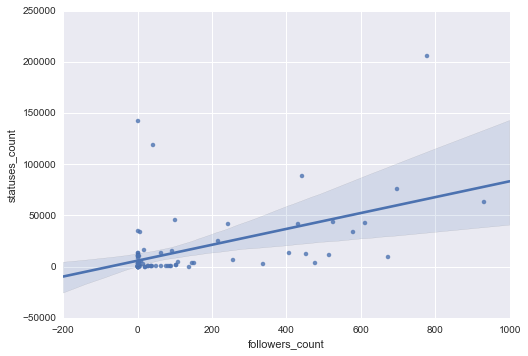

In [18]:
ax = sns.regplot(x="followers_count", y="statuses_count", data=android_or_iphone_df.query('followers_count<1000'))